In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

### Dark theme pour matplotlib ###
from ing_theme_matplotlib import mpl_style

# Méthode pour le calcul des erreurs


In [57]:
def error_p(p,n=1000,Za=1.96) -> float:
    return np.sqrt(p*(1-p)/n)*Za
error_p(0.5,int(1900/9))

def margin_p(p,n=1000,Za=1.96) -> np.array:
    er=error_p(p,n,Za)
    return np.array([p-er,p+er])

def error_in_margin(p,n,variation,Za=1.96,double_margin=True):
    # Compute old values
    old_p=p-variation
    # Compute err
    err=error_p(p/100,n,Za)*100
    # Compute err old values
    old_err=error_p(old_p/100,n,Za)*100
    if double_margin:
        return (np.abs(variation)<=err+old_err) & variation!=0
    else:
        return (np.abs(variation)<=err) & variation!=0

def extract_in_margin(fav,defav,evol_fav,evol_defav,pop_size,double_margin=True):
    # Suppression des valeurs sans variation
    fav=fav[evol_fav!=0]
    defav=defav[evol_defav!=0]
    pop_size_fav=pop_size[evol_fav!=0]
    pop_size_defav=pop_size[evol_defav!=0]
    evol_fav=evol_fav[evol_fav!=0]
    evol_defav=evol_defav[evol_defav!=0]

    # Calcul des erreurs
    err_fav=error_p(fav/100,pop_size_fav)*100
    err_defav=error_p(defav/100,pop_size_defav)*100

    # Calcul des anciennes valeurs
    old_fav=fav-evol_fav
    old_defav=defav-evol_defav
    # Calcul des erreurs anciennes valeurs
    err_old_fav=error_p(old_fav/100,pop_size_fav)*100
    err_old_defav=error_p(old_defav/100,pop_size_defav)*100
    if double_margin:
        total_fav_in_margin=np.sum(err_fav+err_old_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav+err_old_defav>=np.abs(evol_defav))
    else:
        total_fav_in_margin=np.sum(err_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav>=np.abs(evol_defav))
    total_in_margin=total_fav_in_margin+total_defav_in_margin
    total_lines=len(fav)+len(defav)

    return (total_in_margin,total_lines)

# Load all dataframes



## Load method

In [65]:
def load_data(filepath):
    filenames=[f.rstrip('.p') for f in os.listdir(filepath)]
    df=pd.read_pickle("{}/{}.p".format(filepath,filenames[0]))
    all_data=pd.DataFrame(columns=df.columns)
    all_data.Base=all_data.Base.astype(int)
    for fn in filenames:
        df=pd.read_pickle("{}/{}.p".format(filepath,fn))
        if df.Base.dtype==object:
            df.Base=df.Base.astype(int)
        if 'Date' not in df.columns:
            df['Date']=fn
        all_data=pd.concat([all_data,df],ignore_index=True)
        in_margin,nb_lines=extract_in_margin(df['ST Favorable'],df['ST Défavorable'],df['Evolution ST Favorable'],df['Evolution ST Défavorable'],df.Base)
    all_data.Date=all_data.Date.astype('datetime64')
    return all_data

def load_data_perso(filepath):
    filenames=[f.rstrip('.p') for f in os.listdir(filepath)]
    df=pd.read_pickle("{}/{}.p".format(filepath,filenames[0]))
    all_data=pd.DataFrame(columns=df.columns)
    all_data.Base=all_data.Base.astype(int)
    for fn in filenames:
        df=pd.read_pickle("{}/{}.p".format(filepath,fn))
        if df.Base.dtype==object:
            df.Base=df.Base.astype(int)
        all_data=pd.concat([all_data,df],ignore_index=True)
    all_data.rename(columns={'Opinion positive':'ST Favorable'},inplace=True)
    all_data['ST Favorable']=all_data['ST Favorable'].astype(float)
    all_data.Date=all_data.Date.astype('datetime64')
    return all_data


## Load Ipsos


In [39]:
ipsos=load_data('ipsos/data')

Nom                      Categorie          Groupe   Base  \
0       Emmanuel MACRON                       ENSEMBLE        ENSEMBLE  971.0   
1       Emmanuel MACRON                           Sexe           Homme  462.0   
2       Emmanuel MACRON                           Sexe           Femme  509.0   
3       Emmanuel MACRON                            Age     18 à 24 ans  103.0   
4       Emmanuel MACRON                            Age     25 à 34 ans  154.0   
...                 ...                            ...             ...    ...   
36115  Laurent WAUQUIEZ  VotePrésidentielle20171ertour       STNonexpr  238.0   
36116  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour  EmmanuelMacron  410.0   
36117  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour     MarineLePen  210.0   
36118  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour          STExpr  620.0   
36119  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour       STNonexpr  380.0   

       Très favorable  Plutôt favorable  ST Favorable  Plutôt défavorable  \
0                 3.6              26.3          30.0                29.1   
1                 5.2              29.7          34.9                31.6   
2                 2.2              23.3          25.5                26.8   
3                 7.5              14.8          22.3                22.8   
4                 0.2              13.1          13.3                26.2   
...               ...               ...           ...                 ...   
36115             1.4              10.4          11.9                24.3   
36116             3.3              17.8          21.1                31.5   
36117             2.8              24.1          26.9                25.6   
36118             3.1              20.0          23.1                29.5   
36119             2.4              14.0          16.4                26.0   

       Très défavorable  ST Défavorable   Nsp  Evolution ST Favorable  \
0                  17.2            46.3  23.8                     1.4   
1                  19.4            51.0  14.1                     1.7   
2                  15.2            42.0  32.5                     1.1   
3                  10.9            33.8  44.0                     3.4   
4                  18.2            44.4  42.3                    -8.9   
...                 ...             ...   ...                     ...   
36115              19.1            43.5  44.7                     1.8   
36116              30.0            61.5  17.3                    -1.0   
36117              22.4            48.0  25.1                     1.1   
36118              27.4            56.9  20.0                    -0.3   
36119              25.3            51.3  32.3                    -2.5   

       Evolution ST Défavorable       Date  
0                          -2.5 2018-12-08  
1                          -1.1 2018-12-08  
2                          -3.8 2018-12-08  
3                          -0.9 2018-12-08  
4                          -3.2 2018-12-08  
...                         ...        ...  
36115                      -1.1 2021-01-23  
36116                       3.7 2021-01-23  
36117                      -5.5 2021-01-23  
36118                       0.6 2021-01-23  
36119                       3.8 2021-01-23  

[36120 rows x 14 columns]

In [24]:
ipsos.head()

Nom                      Categorie          Groupe  Base  \
0       Emmanuel MACRON                       ENSEMBLE        ENSEMBLE   971   
1       Emmanuel MACRON                           Sexe           Homme   462   
2       Emmanuel MACRON                           Sexe           Femme   509   
3       Emmanuel MACRON                            Age     18 à 24 ans   103   
4       Emmanuel MACRON                            Age     25 à 34 ans   154   
...                 ...                            ...             ...   ...   
36115  Laurent WAUQUIEZ  VotePrésidentielle20171ertour       STNonexpr   238   
36116  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour  EmmanuelMacron   410   
36117  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour     MarineLePen   210   
36118  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour          STExpr   620   
36119  Laurent WAUQUIEZ  VotePrésidentielle20172ndtour       STNonexpr   380   

       Très favorable  Plutôt favorable  ST Favorable  Plutôt défavorable  \
0                 3.6              26.3          30.0                29.1   
1                 5.2              29.7          34.9                31.6   
2                 2.2              23.3          25.5                26.8   
3                 7.5              14.8          22.3                22.8   
4                 0.2              13.1          13.3                26.2   
...               ...               ...           ...                 ...   
36115             1.4              10.4          11.9                24.3   
36116             3.3              17.8          21.1                31.5   
36117             2.8              24.1          26.9                25.6   
36118             3.1              20.0          23.1                29.5   
36119             2.4              14.0          16.4                26.0   

       Très défavorable  ST Défavorable   Nsp  Evolution ST Favorable  \
0                  17.2            46.3  23.8                     1.4   
1                  19.4            51.0  14.1                     1.7   
2                  15.2            42.0  32.5                     1.1   
3                  10.9            33.8  44.0                     3.4   
4                  18.2            44.4  42.3                    -8.9   
...                 ...             ...   ...                     ...   
36115              19.1            43.5  44.7                     1.8   
36116              30.0            61.5  17.3                    -1.0   
36117              22.4            48.0  25.1                     1.1   
36118              27.4            56.9  20.0                    -0.3   
36119              25.3            51.3  32.3                    -2.5   

       Evolution ST Défavorable       Date  
0                          -2.5 2018-12-08  
1                          -1.1 2018-12-08  
2                          -3.8 2018-12-08  
3                          -0.9 2018-12-08  
4                          -3.2 2018-12-08  
...                         ...        ...  
36115                      -1.1 2021-01-23  
36116                       3.7 2021-01-23  
36117                      -5.5 2021-01-23  
36118                       0.6 2021-01-23  
36119                       3.8 2021-01-23  

[36120 rows x 14 columns]

## Load Ifop


In [42]:
ifop=load_data('ifop/data')
ifop.head()

Nom Categorie    Groupe    Base  Très favorable  \
0   Emmanuel MACRON  ENSEMBLE  ENSEMBLE  1928.0             5.0   
1  Edouard PHILIPPE  ENSEMBLE  ENSEMBLE  1928.0             4.0   
2   Emmanuel MACRON  ENSEMBLE  ENSEMBLE  1891.0             5.0   
3  Edouard PHILIPPE  ENSEMBLE  ENSEMBLE  1891.0             3.0   
4   Emmanuel MACRON  ENSEMBLE  ENSEMBLE  1929.0             4.0   

   Plutôt favorable  ST Favorable  Plutôt défavorable  Très défavorable  \
0              22.0          27.0                32.0              40.0   
1              26.0          30.0                36.0              31.0   
2              23.0          28.0                34.0              37.0   
3              28.0          31.0                36.0              30.0   
4              25.0          29.0                36.0              33.0   

   ST Défavorable  Nsp  Evolution ST Favorable  Evolution ST Défavorable  \
0            72.0  1.0                     4.0                      -4.0   
1            67.0  3.0                    -1.0                       1.0   
2            71.0  1.0                     1.0                      -1.0   
3            66.0  3.0                     1.0                      -1.0   
4            69.0  2.0                     1.0                      -2.0   

        Date  
0 2019-01-19  
1 2019-01-19  
2 2019-02-16  
3 2019-02-16  
4 2019-03-23

## Load Ifop personalités

In [66]:
ifop_pers=load_data_perso('ifop/data_perso')
ifop_pers.head()

Nom    Base       Date  ST Favorable
0     Nicolas HULOT  1008.0 2020-01-11          72.0
1     Martine AUBRY  1008.0 2020-01-11          45.0
2   Nicolas SARKOZY  1008.0 2020-01-11          44.0
3  Edouard PHILIPPE  1008.0 2020-01-11          44.0
4    Ségolène ROYAL  1008.0 2020-01-11          44.0

# Comparaison des résultats des instituts de sondages 
## Calcul des erreurs théoriques


In [60]:
def compute_error(df,col):
    return error_p(df[col]/100,df.Base)*100

### Ajout des erreurs sur les mesures

In [86]:
ipsos['Erreur ST Fav']=compute_error(ipsos,'ST Favorable')
ipsos['Erreur ST Defav']=compute_error(ipsos,'ST Défavorable')
ipsos['Erreur Nsp']=compute_error(ipsos,'Nsp')
ifop['Erreur ST Fav']=compute_error(ifop,'ST Favorable')
ifop['Erreur ST Defav']=compute_error(ifop,'ST Défavorable')
ifop['Erreur Nsp']=compute_error(ifop,'Nsp')
ifop_pers['Erreur ST Fav']=compute_error(ifop_pers,'ST Favorable')

### Import du theme sombre pour matplotlib


In [71]:
mpl_style(dark=True)

# Différence de popularité du président et des premiers ministres

Les jeux de données IFOP contiennent très peu de personnes (président et premiers ministres)

In [72]:
noms_en_commun=[x for x in ifop.Nom.unique() if x in ipsos.Nom.unique()]

In [88]:
def plot_with_error(df1,df2,liste_noms,col,err_col,labels=['df1','df2']):
    for nom in liste_noms:
        plt.figure(figsize=(10,8))
        data=df1[df1.Nom==nom]
        sns.lineplot(x='Date',y=col,data=data)
        plt.fill_between(x=data.Date,\
            y1=data[col]-data[err_col],\
            y2=data[col]+data[err_col],\
                alpha=0.25)
        data=df2[(df2.Nom==nom)]
        sns.lineplot(x='Date',y=col,data=data)
        plt.fill_between(x=data.Date,\
            y1=data[col]-data[err_col],\
            y2=data[col]+data[err_col],\
                alpha=0.25)
        plt.legend(labels=labels)

## Soutiens favorables

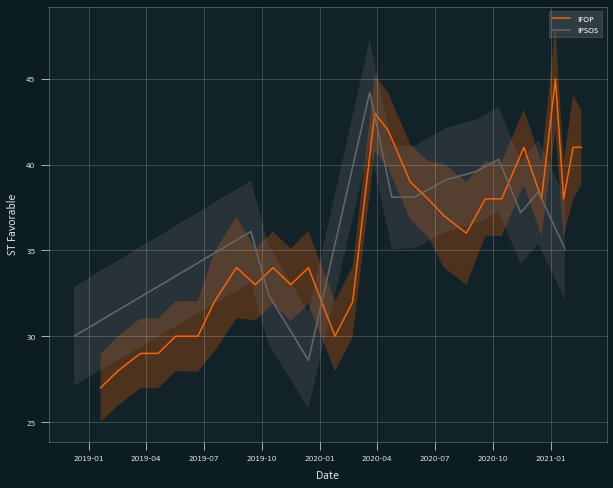

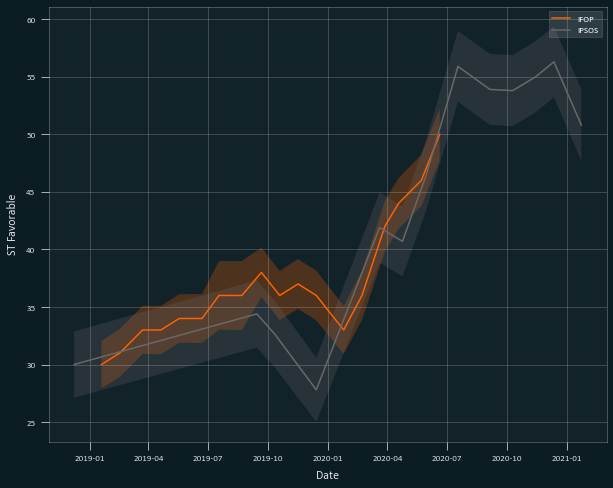

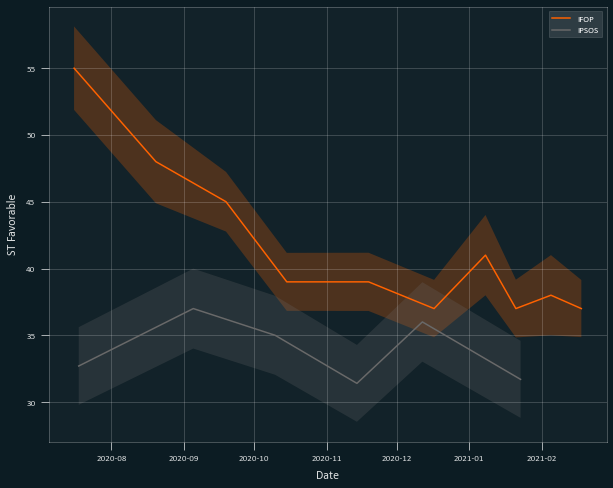

In [89]:
plot_with_error(ifop,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'ST Favorable','Erreur ST Fav',['IFOP','IPSOS'])

## Soutien défavorables

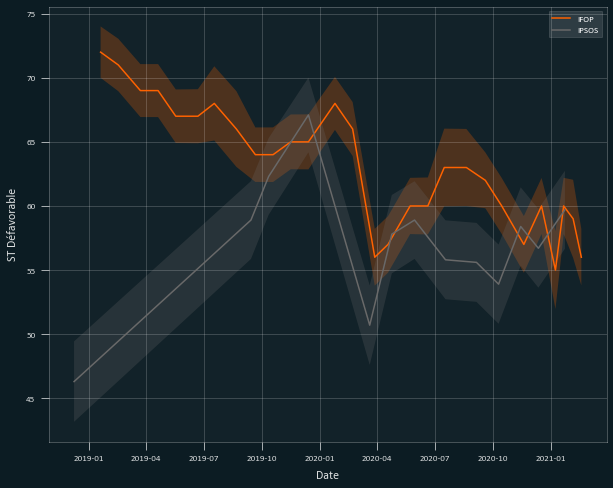

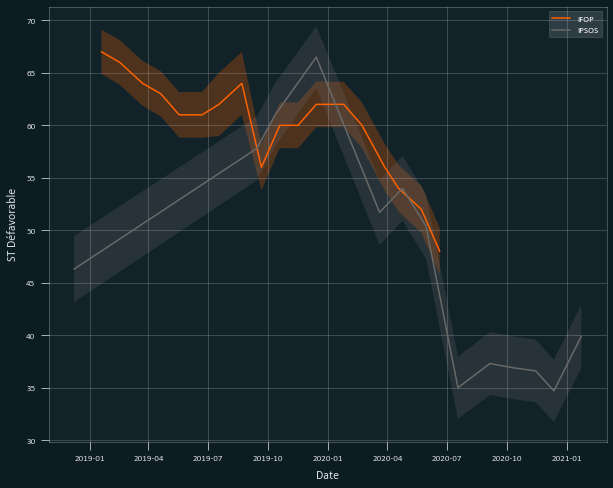

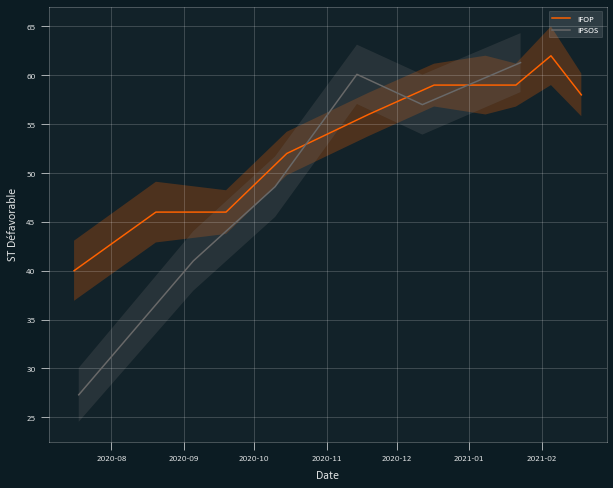

In [90]:
plot_with_error(ifop,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'ST Défavorable','Erreur ST Defav',['IFOP','IPSOS'])


## Ne se prononcent pas

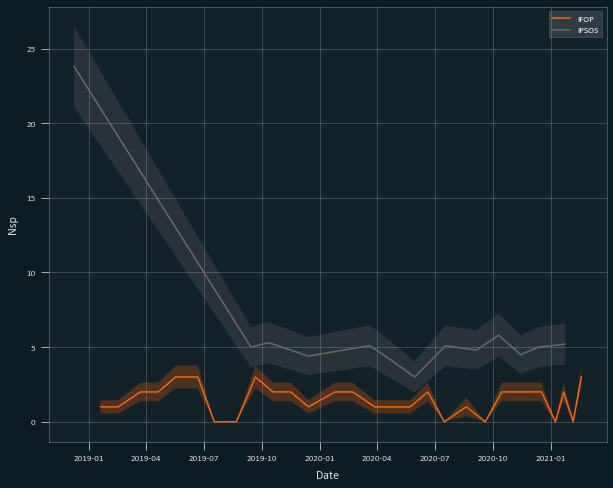

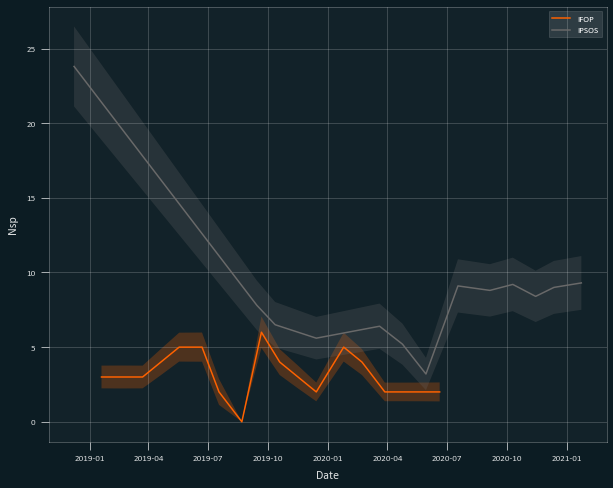

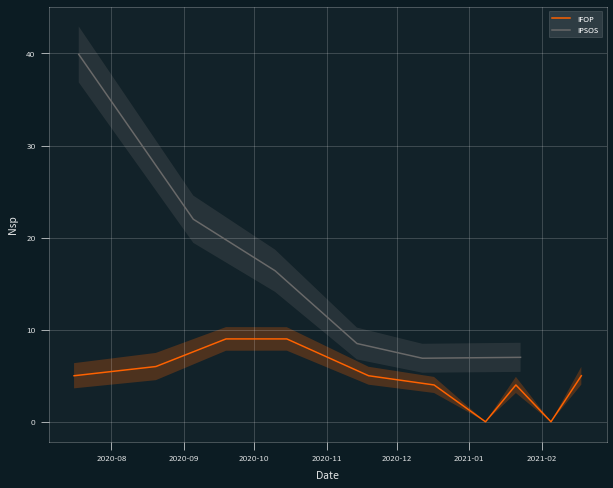

In [91]:
plot_with_error(ifop,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'Nsp','Erreur Nsp',['IFOP','IPSOS'])

# Comparaison des scores par personnalité

On utilisera pour cela les mêmes données pour ipsos. Il faut noter la différence de question entre le deux sondages.
* IFOP demande l'opinion du sondés sur chaque personnalité. Le score est la somme des très bonnes opinons et des bonnes opinions.
* IPSOS demande l'opinion sur __l'action__ de la personnalité. Le système de score est la somme des soutiens très favorables et favorables.

Bien que les questions et les réponses sont différentes dans leurs formulations, beaucoup de personnalités non pas d'action particulière qui puisse être connue notoirement. Néanmoins on observe que le nombre de ne se prononce pas est relativement faible malgré cela.

In [92]:
noms_en_commun=[x for x in ifop_pers.Nom.unique() if x in ipsos.Nom.unique()]

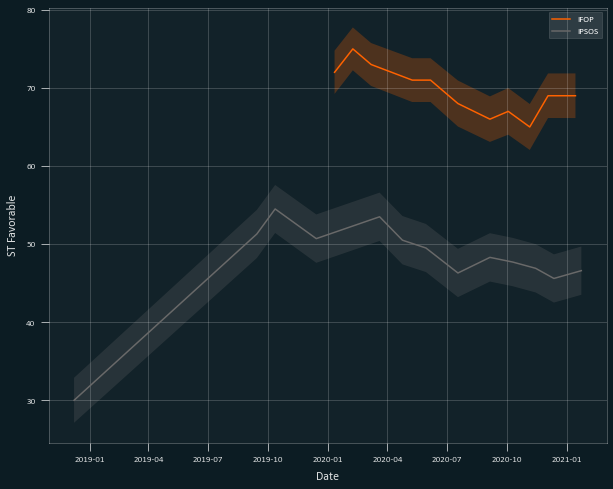

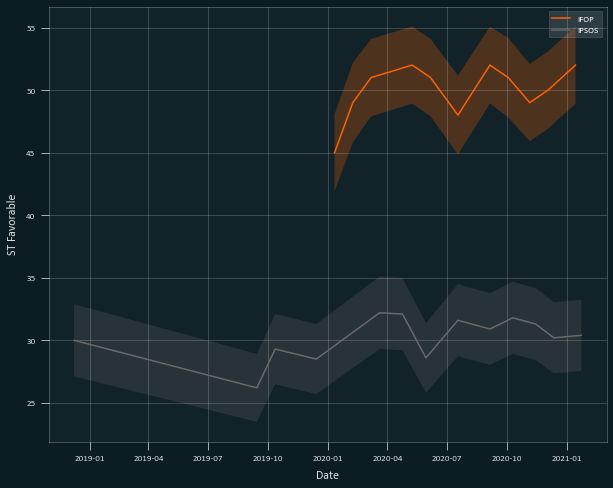

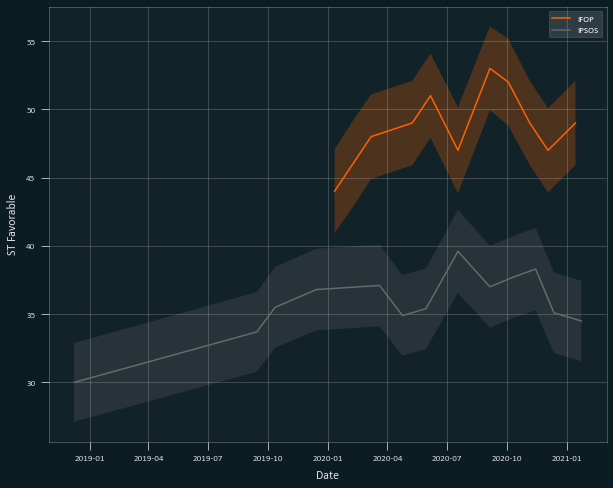

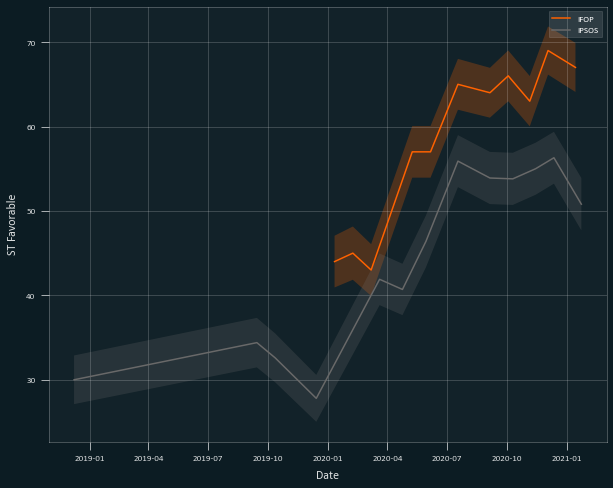

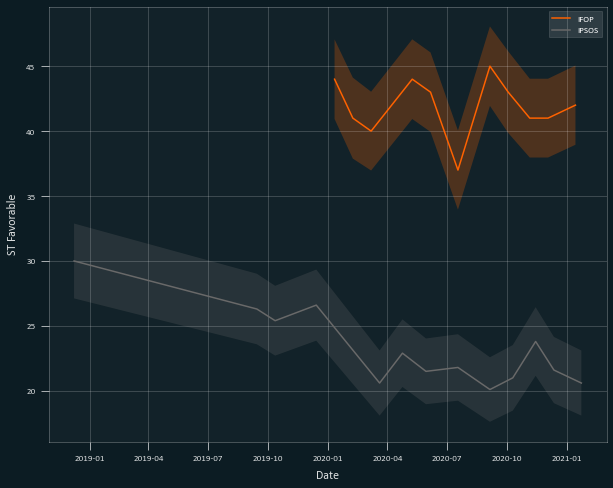

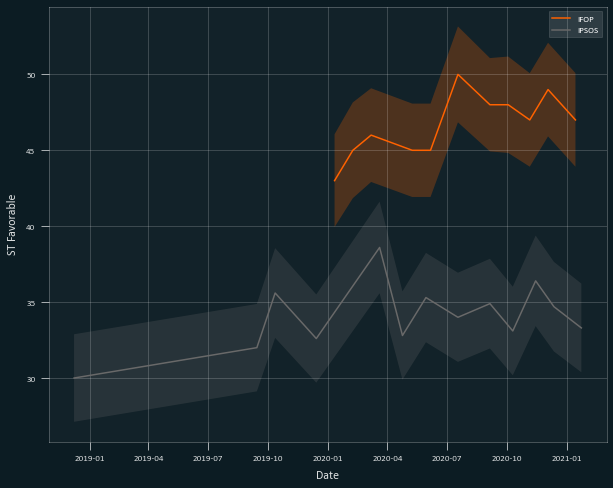

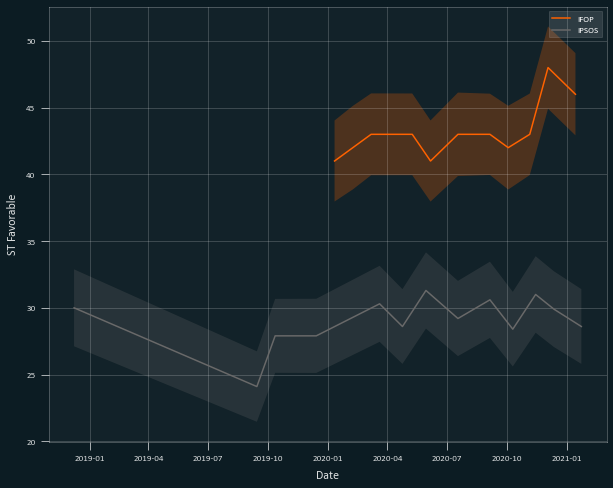

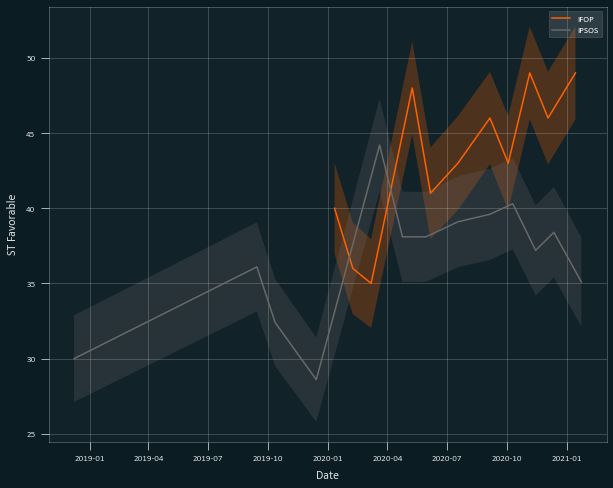

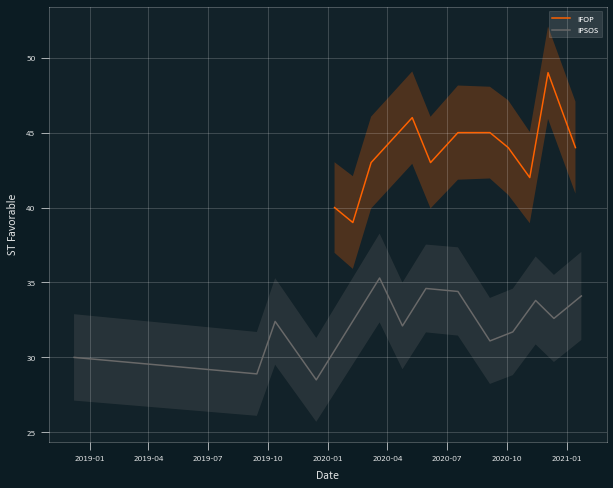

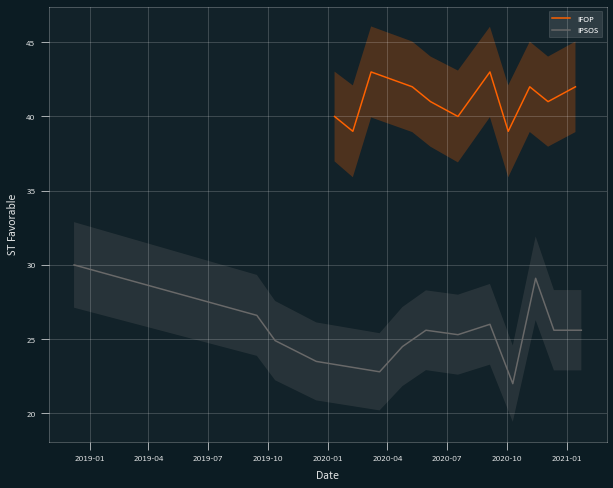

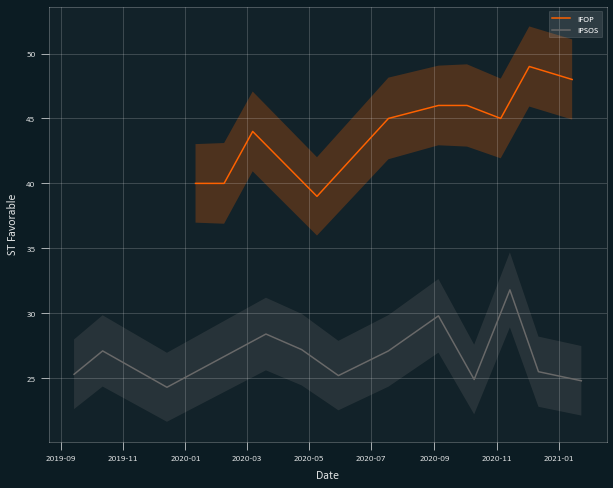

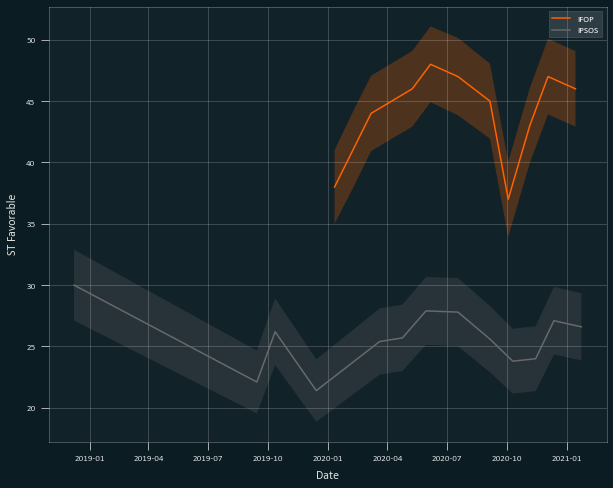

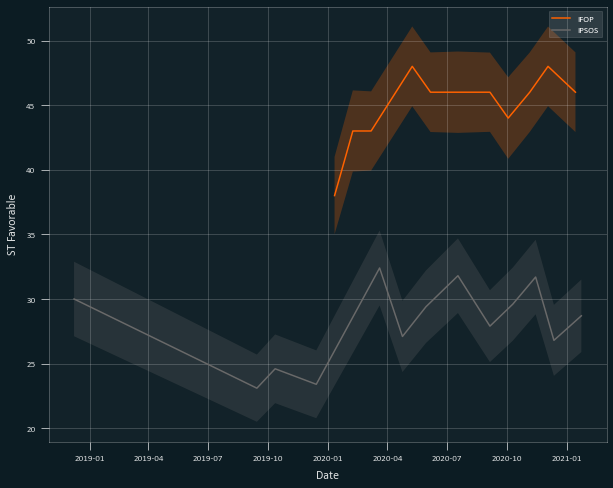

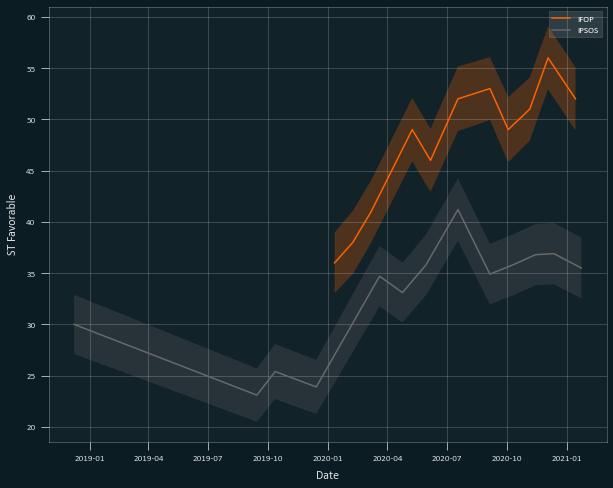

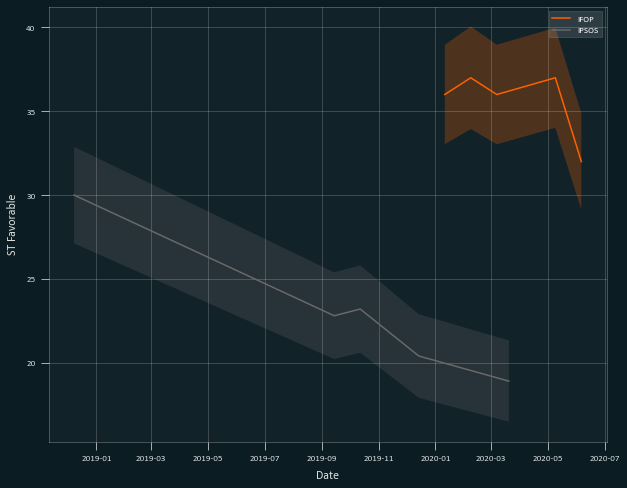

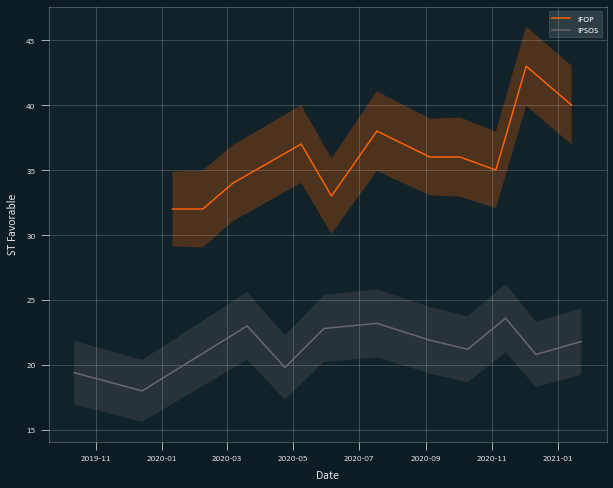

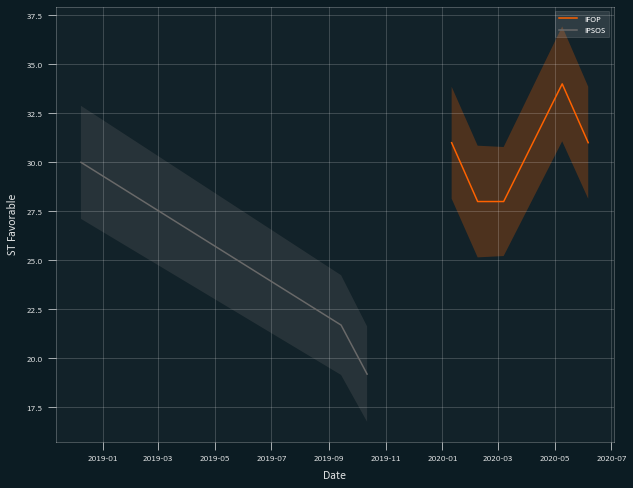

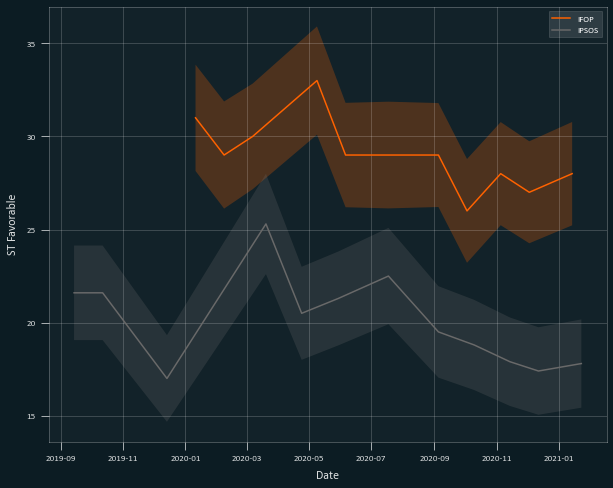

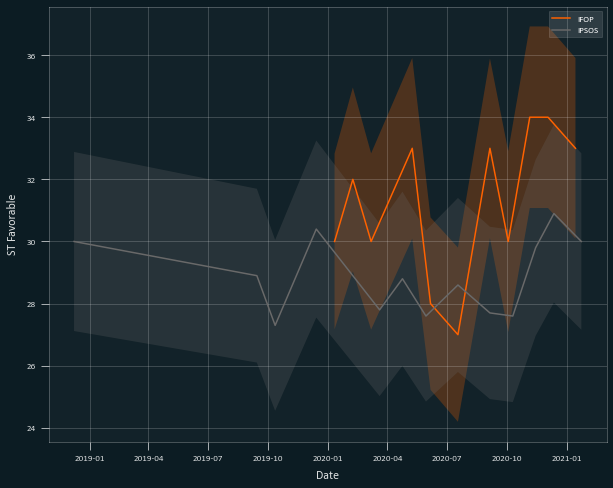

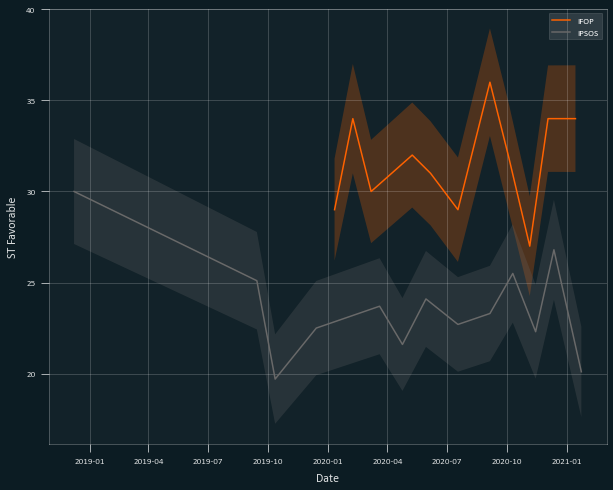

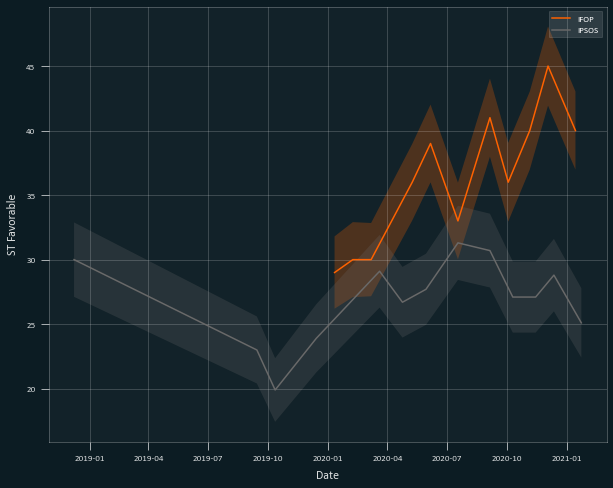

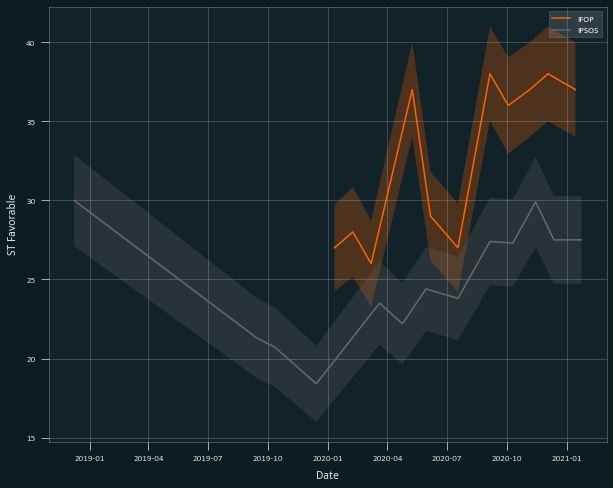

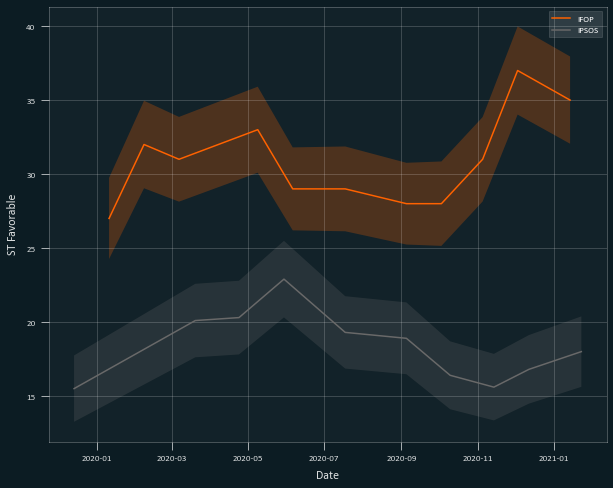

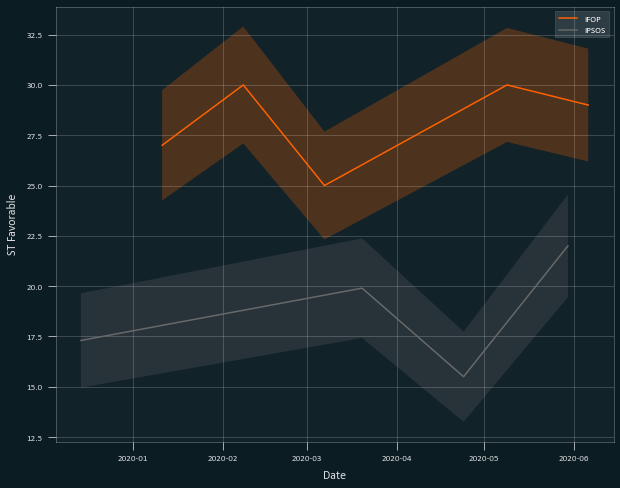

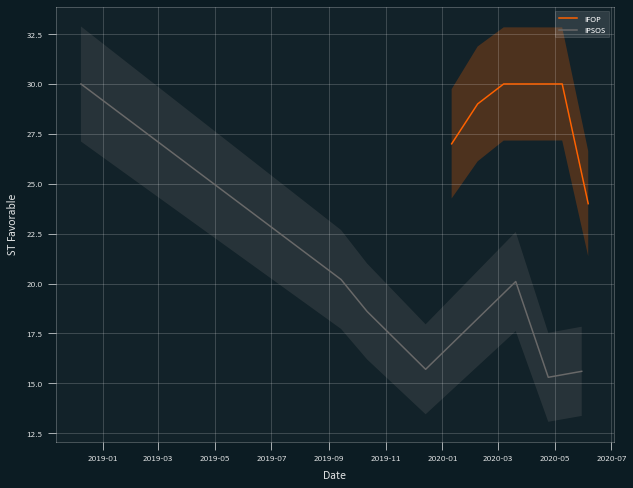

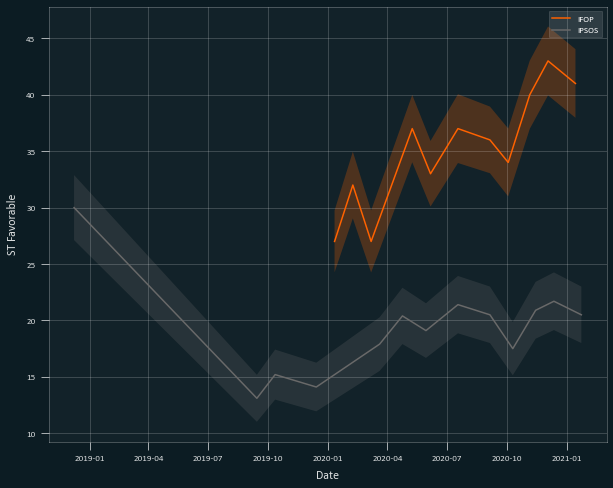

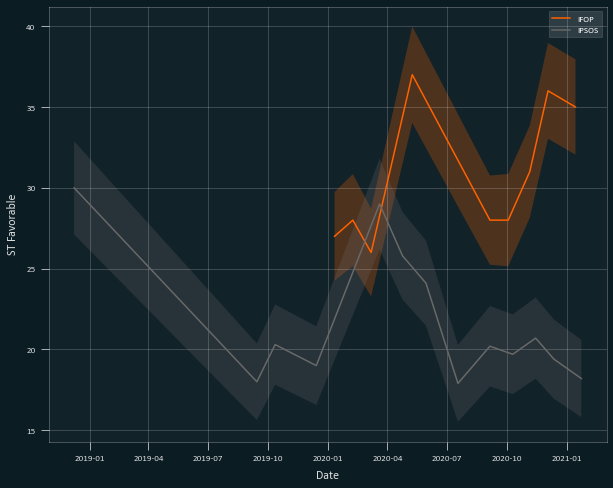

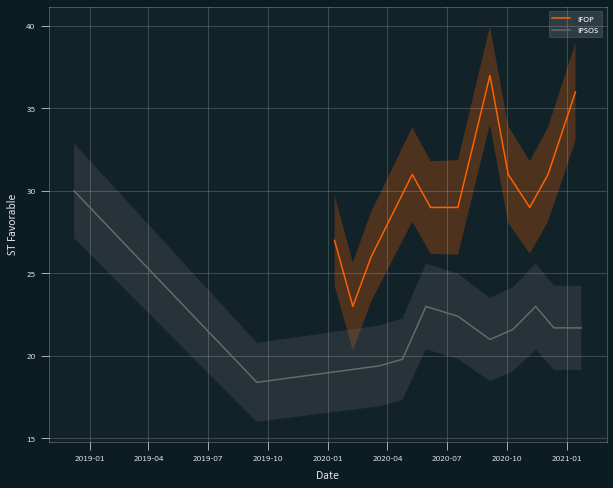

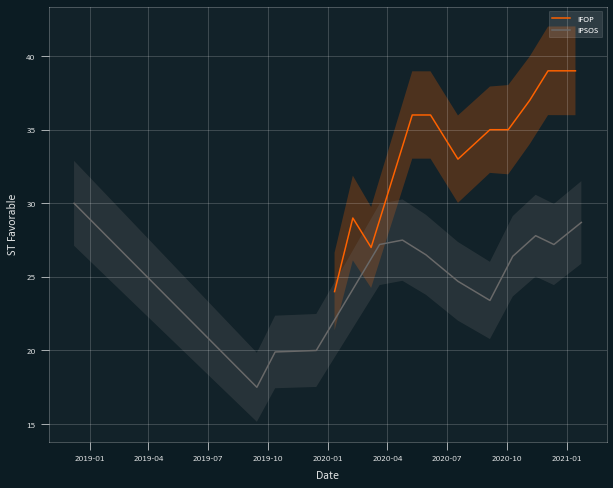

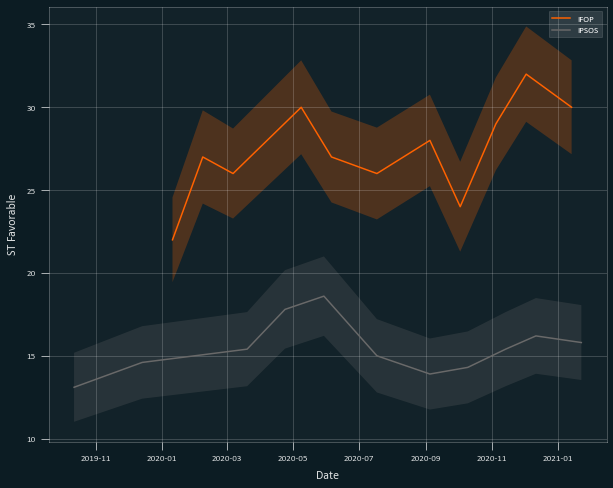

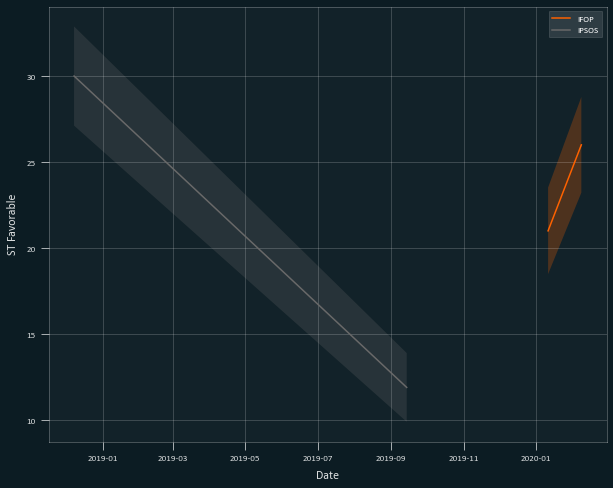

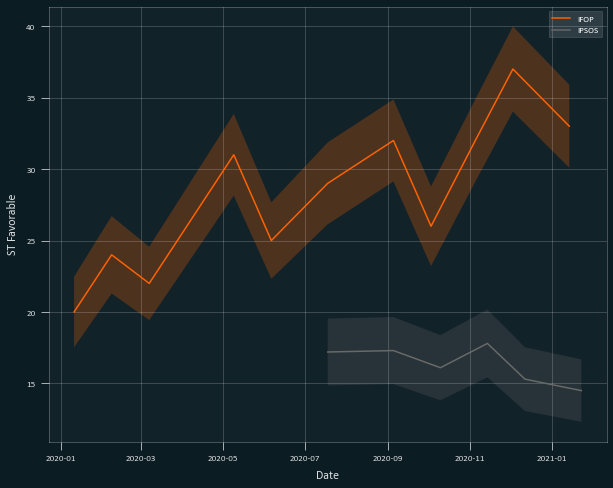

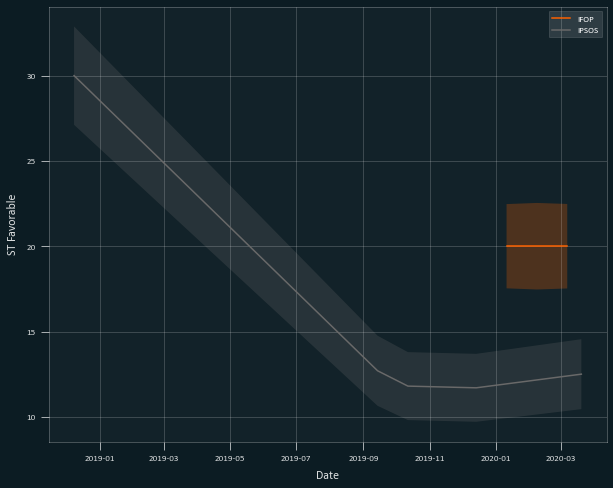

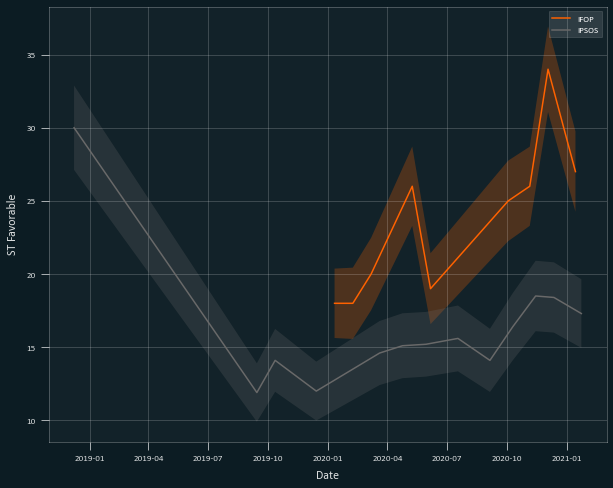

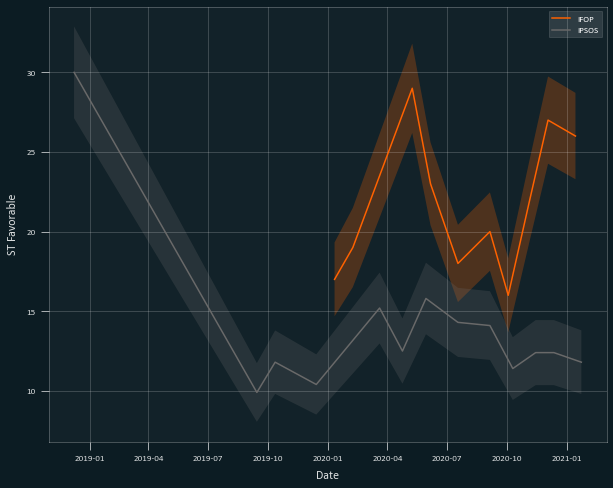

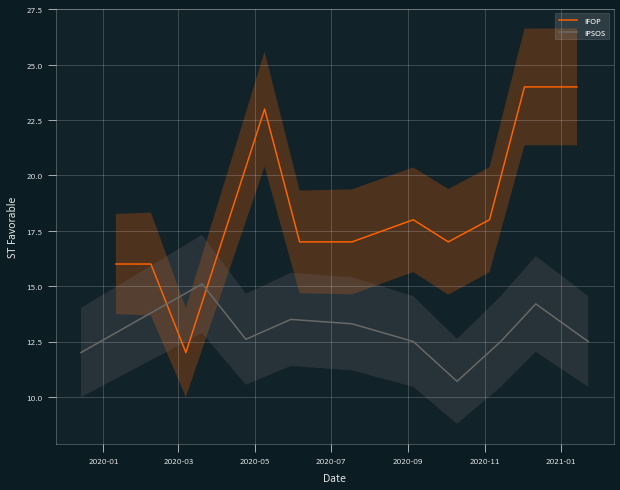

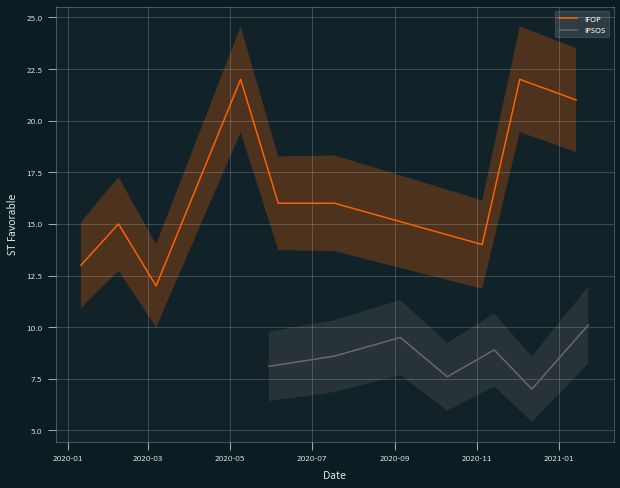

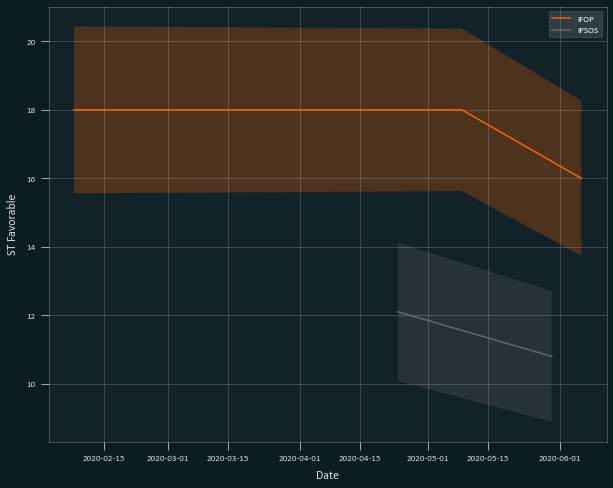

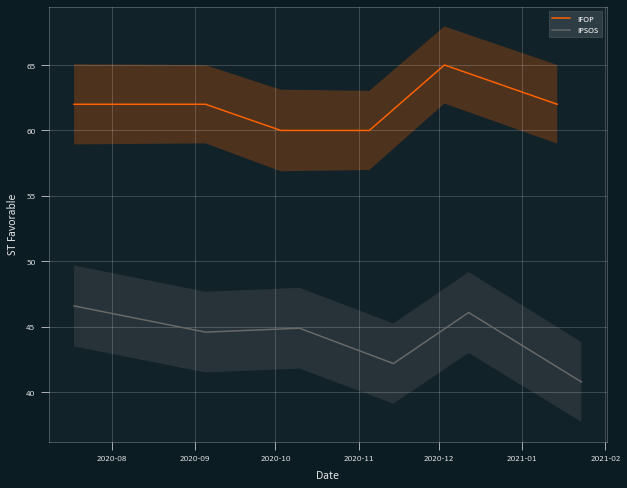

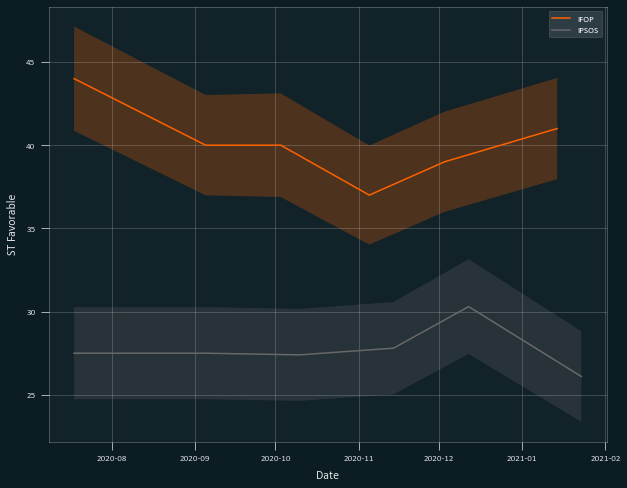

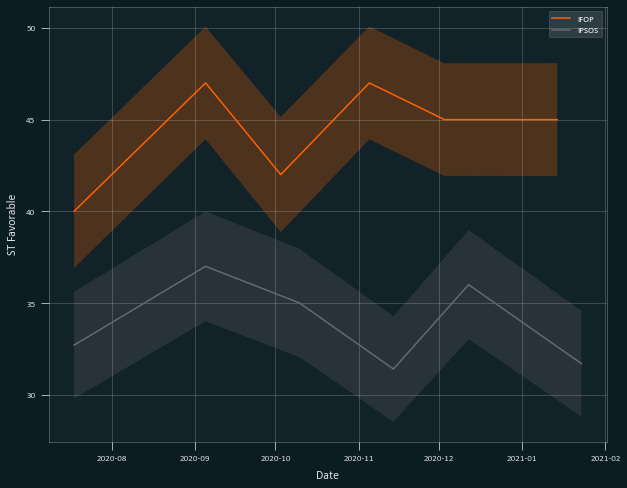

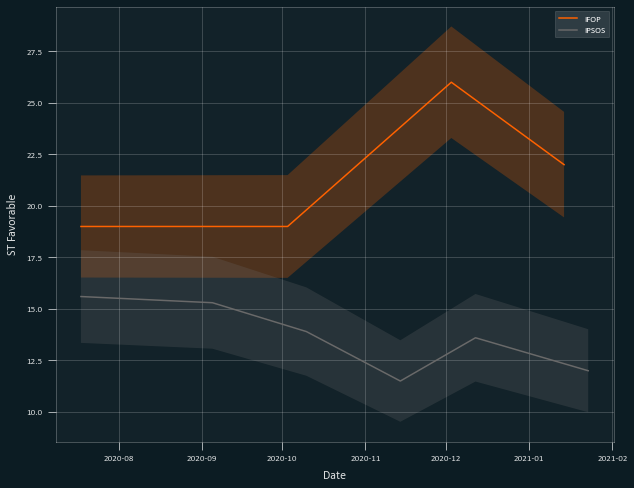

In [94]:
plot_with_error(ifop_pers,ipsos[ipsos.Groupe=='ENSEMBLE'],noms_en_commun,'ST Favorable','Erreur ST Fav',['IFOP','IPSOS'])